In [56]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import math as math
# --- Theme Configuration ---
# Feel free to experiment with these colors!
BACKGROUND_COLOR = '#2c3e50'  # Dark slate blue
AXES_FACE_COLOR = '#34495e'   # Slightly lighter slate blue
TEXT_COLOR = '#ecf0f1'       # Light silver/off-white
ACCENT_COLOR_1 = '#e74c3c'     # Bright red
ACCENT_COLOR_2 = '#3498db'     # Bright blue
ACCENT_COLOR_3 = '#f1c40f'     # Bright yellow
GRID_COLOR = '#7f8c8d'       # Muted gray for grid
SPINE_COLOR = '#95a5a6'      # Slightly lighter gray for spines
LEGEND_FACE_COLOR = '#34495e'
LEGEND_EDGE_COLOR = '#ecf0f1'

In [4]:
# ---- add near the top of your script ----
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

def add_planet_photo(ax, x_c3, img_path, *, y_frac=0.88, zoom=0.18):
    """
    ax     : matplotlib Axes
    x_c3   : x position (your C3 value, same as the vertical line x)
    img_path: path to a PNG/JPG of the planet (transparent PNG looks best)
    y_frac : vertical placement as a fraction of the axes height (0=bottom, 1=top)
    zoom   : image scale; tweak per planet size
    """
    img = mpimg.imread(img_path)
    oi = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(
        oi, (x_c3, y_frac),
        xycoords=('data', 'axes fraction'),  # x in data (C3), y as axes fraction
        frameon=False,
        box_alignment=(0.5, 0.5),
        zorder=10,   # above lines
        pad=0.0
    )
    ax.add_artist(ab)
    
    
def add_planet_on_c3(ax, x_c3, img_path, *, y_frac=0.90, zoom=0.22, z=10):
    """
    Place a planet image centered on the vertical line at x_c3.
    y_frac is 0..1 in axes coordinates so the image 'floats' above the curves.
    """
    img = mpimg.imread(img_path)              # transparent PNG looks best
    ab = AnnotationBbox(
        OffsetImage(img, zoom=zoom),
        (x_c3, y_frac),
        xycoords=('data', 'axes fraction'),   # x in data (C3), y in axes fraction
        frameon=False,
        box_alignment=(0.5, 0.5),
        # zorder=zorder,
        pad=0.0
    )
    ax.set_zorder(z)
    ax.add_artist(ab)
    


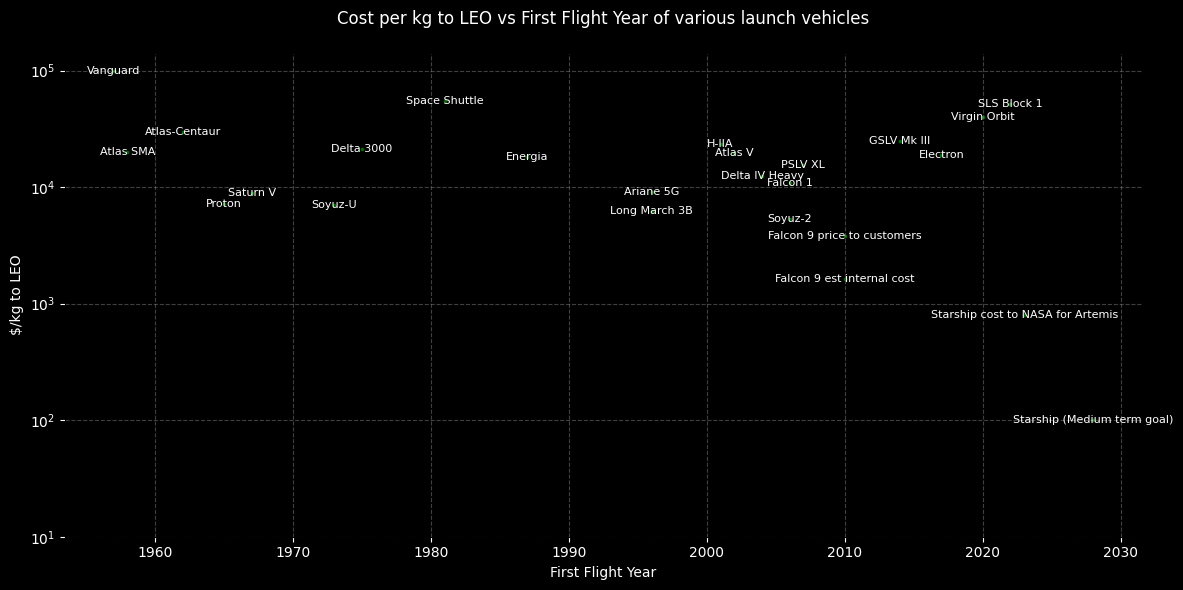

In [1]:

import matplotlib.pyplot as plt

# Data without N1, constant bubble size
rockets = [
    "Vanguard", "Atlas SMA", "Atlas-Centaur", "Saturn V", "Delta 3000","Space Shuttle", "Energia",
    "Proton", "Soyuz-2", "Falcon 1", "Delta IV Heavy", "Atlas V", "Ariane 5G",
    "Long March 3B", "PSLV XL", "H-IIA", "GSLV Mk III", "Electron", 
    "Virgin Orbit", "Falcon 9 price to customers", "Falcon 9 est internal cost", "SLS Block 1", "Starship cost to NASA for Artemis","Starship (Medium term goal)", "Soyuz-U"
]

# rockets = [
#     "Vanguard", "Atlas-Centaur","Saturn V","Space Shuttle", "Soyuz-2", "Atlas V",
#      "Falcon 9", "Falcon Heavy B5", "SLS Block 1", "Starship", "Ariane 5"
# ]

first_flight = [
    1957, 1958, 1962, 1967, 1975, 1981, 1987,
    1965, 2006, 2006, 2004, 2002, 1996,
    1996, 2007, 2001, 2014, 2017, 2020,
    2010, 2010, 2022, 2023, 2028, 1973 
]

# first_flight = [
# 1958, 1962, 1967, 1981, 2006, 2002,
# 2010, 2019, 2022, 2023, 1996
# ]

cost_per_kg = [
    100000, 20000, 29500, 8900, 21400, 54500, 18000,
    7220, 5333, 10754, 12340, 19500, 9167,
    6200, 15450, 23500, 25000, 19039, 40000,
    3800, 1620, 52100, 800, 100, 7000
]

# cost_per_kg = [
#     100000,20000, 8900,  54500, 5340 ,19500,
#     1820, 1500, 52100, 100, 9200
# ]

# Create bubble chart with constant size
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

constant_size = 3  # constant bubble size for all

ax.scatter(first_flight, cost_per_kg, s=constant_size, color='green', alpha=0.7)

# Centered annotations
for x, y, label in zip(first_flight, cost_per_kg, rockets):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='white')

# Styling
ax.set_xlabel("First Flight Year", color='white')
ax.set_ylabel("$/kg to LEO", color='white')
ax.set_title("Cost per kg to LEO vs First Flight Year of various launch vehicles\n", color='white')
ax.set_yscale('log')
ax.grid(True, color='gray', linestyle='--', alpha=0.5)
ax.tick_params(colors='white')

# # Highlight "Starship" label
# starship_idx = rockets.index("Starship")
# x_starship = first_flight[starship_idx]
# y_starship = cost_per_kg[starship_idx]

# ax.annotate(
#     "★ Starship",
#     xy=(x_starship, y_starship),
#     xytext=(x_starship+2, y_starship*1.5),
#     color='yellow',
#     fontsize=14,
#     fontweight='bold',
#     arrowprops=dict(facecolor='yellow', arrowstyle='->'),
#     ha='left'
# )
plt.ylim(bottom=10)

plt.tight_layout()
plt.show()


In [6]:
from io import BytesIO
from PIL import Image
# Open an image from a computer 
def open_image_local(path_to_image):
    image = Image.open(path_to_image) # Open the image
    image_array = np.array(image) # Convert to a numpy array
    return image_array # Output

I'm taking the LEO payload of the rocket as the maximum amount of excess propellant in the tanks of the upper stage once it reaches orbit

In [7]:

# performance = { 'Rocket': [wet mass (kg), dry mass (kg), vacuum Isp (s)] }
performance = {
    # [wet_mass_kg, dry_mass_kg, Isp_s, LEO_payload_kg]
    'Atlas V 551':              [23077, 2247, 449.7,   18850],
    'Falcon 9 RTLS':        [111500, 4200, 348,    15000],   # fully‑fuelled second stage
    'Falcon 9 expended':        [111500, 4200, 348,    22800],   # fully‑fuelled second stage
    'Falcon Heavy expended':    [111500, 4200, 348,  63800],
    'Delta IV Heavy':           [30700,  3480, 465.5,  28790],
    'SLS Block 1B':             [143000,  14000, 460, 105000],
    'Saturn V':[123000,13500,420,145000],
    'Unrefuelled Starship':[1300000,120000,380,250000],
    'Starship refuelled in LEO':[1300000,120000,380,  1450000],
    'Starship refuelled in HEO':[1300000,120000,380,  1450000],
    'Light Starship refuelled in HEO':[1300000,80000,380,  1450000],
}
# #all assume starting in orbit with periapsis of 200km, but have some DV penalty/bonus from use of upper stage to reach LEO/HEO Starship & SLS bonus
# performance = {
#     # [wet_mass_kg, dry_mass_kg, Isp_s, LEO_payload_kg]
#     'Atlas V 551':              [23077, 2247, 449.7,   18850],
#     # 'Falcon 9 expended':        [111500, 4000, 348,    22800],   # fully‑fuelled second stage
#     # 'Falcon Heavy expended':    [111500, 4000, 348,    63800],
#     # 'Delta IV Heavy':           [30700,  3480, 465.5,  28790],
#     # 'SLS Block 1B':             [143000,  14000, 460, 105000],
#     'Unrefuelled Starship':[1300000,120000,380,250000],
#     'Starship refuelled in LEO':[1300000,120000,380,  1450000],
#     # 'Starship refuelled in HEO':[1300000,120000,380,  1450000],
#     'Stripped Starship refuelled in HEO':[1300000,80000,380,  1450000],
# }    




Need to calculate the payload mass of various rockets as a function of C3. C3 is the energy given as:
$$
\frac{C_3}{2}=\frac{v^2}{2}-\frac{\mu}{r}
$$
This is only positive for objects on escape velocity trajectories. Once we know the DV of the spacecraft, it is easy to calculate this number numerically starting from HEO (eg SLS or Starship) or analytically from LEO (even easier). The issue is that for all vehicles that do not utilize in orbit refuelling, the LEO/HEO DV is a function of payload mass, and this is not publically avaliable info. We can make a first pass assuming that the second stage reaches orbit with propellant roughly equal to the vehicles max LEO payload minus the actual payload mass. 

<!-- We can make a first pass assuming constant DV to reach orbit (not a terrible assumption since all listed vehicles have reasonably high TWR, so gravity losses are reduced) -->

The only major problem is SLS as LEO payload > 2nd stage prop mass for block 1. I suppose I could just do B1B. 


In [8]:
#Light DV calc
isp = 380.5 #348 mvac, 380 rvac, 421 j2, 450.5 Rl10
payload = 122000
dry_mass = 122050#dry mass of upper stage not including payload
max_payload_leo = 1500000
dv = 9.81*isp*np.log((max_payload_leo+dry_mass)/(payload+dry_mass))
print(f"{dv}m/s")


7070.0155260658585m/s


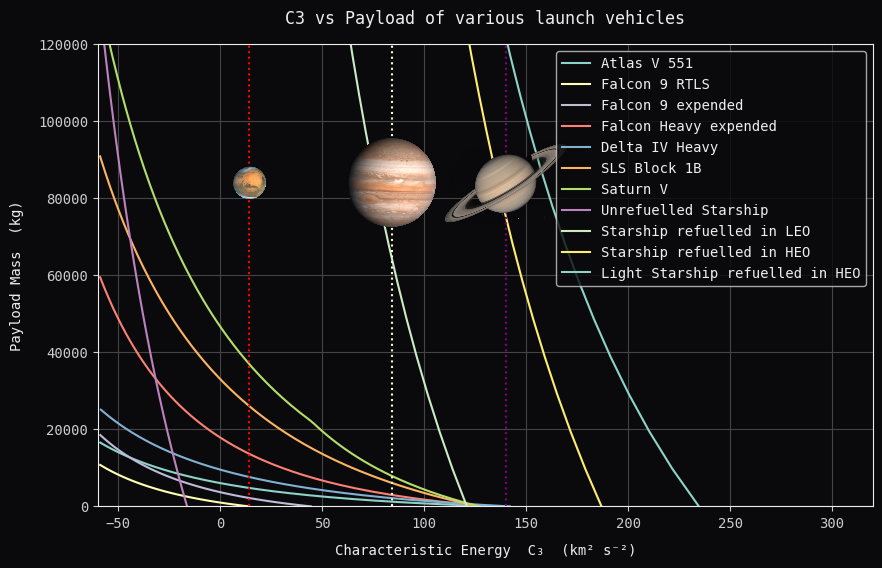

In [10]:
g0 = 9.80665  # m/s^2
v_leo = 7780  # m/s (circular velocity at ~200 km)
v_escape = 10930  # m/s (escape velocity at same altitude)

fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('dark_background') # Start with a dark base

# ----------  Retro‑Sci‑Fi Matplotlib Theme  ----------
plt.rcParams.update({
    'figure.facecolor': '#0A0A0C',
    'axes.facecolor':   '#0A0A0C',
    'axes.edgecolor':   '#EEEEEE',
    'axes.labelcolor':  '#EEEEEE',
    'text.color':       '#EEEEEE',
    'xtick.color':      '#CCCCCC',
    'ytick.color':      '#CCCCCC',
    'grid.color':       '#444444',
    'font.family':      'monospace',
    'axes.titlepad':    15,
})

for lv, (wet_mass, dry_mass, isp, leo_cap) in performance.items():
    prop_capacity = wet_mass - dry_mass
    # sample 150 points between a small payload (1 kg) and the LEO capability
    payloads = np.linspace(1, leo_cap, 150)
    c3_vals = []
    valid_payloads = []
    for p in payloads:
        available_prop = leo_cap - p - dry_mass
        # cap by tank capacity and ignore negative available propellant
        if available_prop <= 0:
            continue
        available_prop = min(available_prop, prop_capacity)
        delta_v = 0.87*isp * g0 * np.log((available_prop+dry_mass+p)/ (dry_mass + p))
        if lv == 'Starship refuelled in HEO' or lv == 'Light Starship refuelled in HEO':
            delta_v += 2000
        c3 = (v_leo + delta_v)**2 - v_escape**2  # m^2/s^2
        c3_vals.append(c3 / 1e6)  # convert to km^2/s^2
        valid_payloads.append(p)
    if c3_vals:
        ax.plot(c3_vals, valid_payloads, label=lv)


def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


# Axis labels and title with retro flavour
ax.set_xlabel('Characteristic Energy  C₃  (km² s⁻²)', labelpad=10)
ax.set_ylabel('Payload Mass  (kg)', labelpad=10)
plt.title('C3 vs Payload of various launch vehicles')
ax.grid(True)
# #ax.tight_layout()
plt.axvline(x = 14, linestyle='dotted', color = 'red')
plt.axvline(x = 84, linestyle='dotted', color = 'beige')
plt.axvline(x = 140, linestyle='dotted', color = 'purple')
add_planet_on_c3(ax, 140, "saturn.png",  y_frac=0.70, zoom=0.062)  # lower to dodge legend, rings fit
add_planet_on_c3(ax, 14, "mars.png",  y_frac=0.70, zoom=0.052)  # lower to dodge legend, rings fit
add_planet_on_c3(ax, 84, "jupiter.png",  y_frac=0.70, zoom=0.082)  # lower to dodge legend, rings fit

# plt.axhline(y=9000)
# plt.axhline(y=16800)

ax.legend(loc='upper right')
plt.xlim(left = -60,right=320)
plt.ylim(top = 120000,bottom = 0)
plt.show()

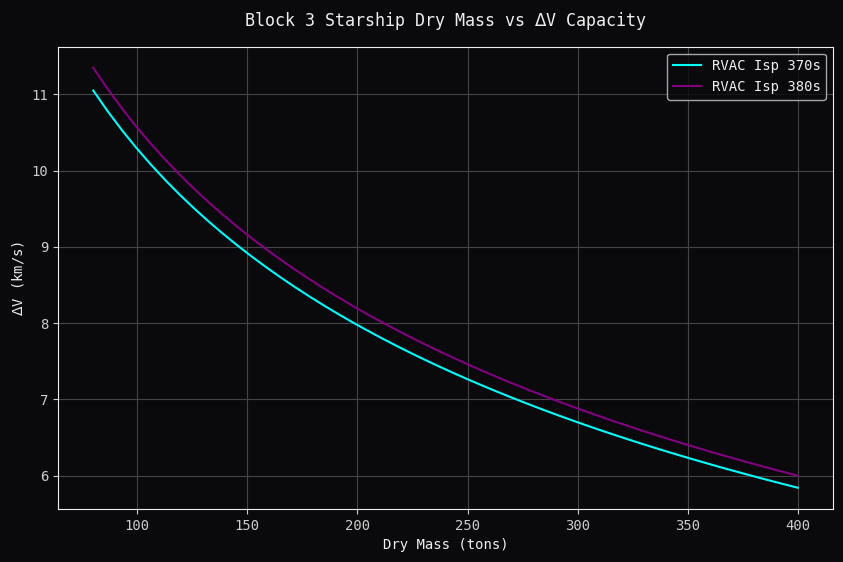

In [63]:
prop_load = 1600
dry_mass = np.linspace(80,400,50)
dv_1 = 9.81*370*np.log((prop_load+dry_mass)/dry_mass)*1e-3
dv_2 = 9.81*380*np.log((prop_load+dry_mass)/dry_mass)*1e-3

fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('dark_background') # Start with a dark base

# ----------  Retro‑Sci‑Fi Matplotlib Theme  ----------
plt.rcParams.update({
    'figure.facecolor': '#0A0A0C',
    'axes.facecolor':   '#0A0A0C',
    'axes.edgecolor':   '#EEEEEE',
    'axes.labelcolor':  '#EEEEEE',
    'text.color':       '#EEEEEE',
    'xtick.color':      '#CCCCCC',
    'ytick.color':      '#CCCCCC',
    'grid.color':       '#444444',
    'font.family':      'monospace',
    'axes.titlepad':    15,
})

ax.plot(dry_mass, dv_1, label='RVAC Isp 370s', color='cyan')
ax.plot(dry_mass, dv_2, label='RVAC Isp 380s', color='purple')
ax.grid(True)


ax.legend(loc='upper right')

plt.title("Block 3 Starship Dry Mass vs $\Delta$V Capacity")
plt.xlabel("Dry Mass (tons)")
plt.ylabel("$\Delta$V (km/s)")
plt.show()

Text(0.5, 1.0, 'Block 3 Starship: Refuels vs Delta-V Saved')

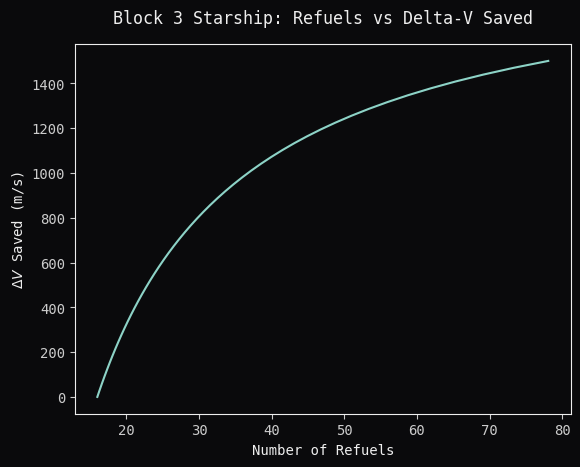

In [ ]:
#Starting with a baseline 200km parking orbit, plot graph of saved DV versus number of refuels,
#So, with a block3 starship, dry mass ~140 tons, isp ~380s, propellant load ~1600 tons, LEO payload 100T
#assuming each tanker goes to HEO without refuels


prop_mass = 1600
tanker_prop = 100
dry_mass = 140
isp=380
DV_saved = np.linspace(0,1500,50)
# p=DV_saved/(10*isp)
Tanker_Final_Mass = (dry_mass+tanker_prop)*np.exp(-DV_saved/(9.81*isp))
No_Refuels = prop_mass/(Tanker_Final_Mass - dry_mass)

plt.plot(No_Refuels,DV_saved)
plt.xlabel("Number of Refuels")
plt.ylabel("$\Delta V$ Saved (m/s)")
plt.title("Block 3 Starship: Refuels vs Delta-V Saved")


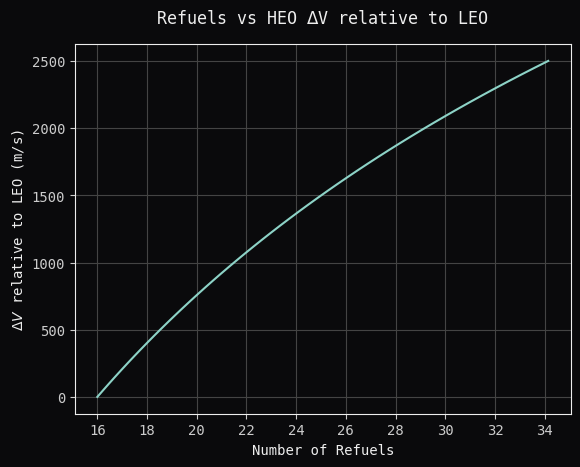

In [64]:
from matplotlib.ticker import MaxNLocator


#suspicious method for calculating the number of refuels needed to reach a given 

prop_mass = 1600
tanker_prop = 100
refuels_per_ship = prop_mass/tanker_prop


dry_mass = 140
isp=380
DV_saved = np.linspace(0,2500,50)
# p=DV_saved/(10*isp)
Tanker_Final_Mass = (dry_mass+prop_mass)*np.exp(-DV_saved/(9.81*isp))
No_Tanker_Refuels = refuels_per_ship*prop_mass/(Tanker_Final_Mass - dry_mass)
No_Refuels = No_Tanker_Refuels#+np.ceil(No_Tanker_Refuels/(refuels_per_ship))
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(No_Refuels,DV_saved)

plt.xlabel("Number of Refuels")
plt.ylabel("$\Delta V$ relative to LEO (m/s)")
plt.title("Refuels vs HEO $\Delta$V relative to LEO")
plt.grid(True)
plt.show()


In [8]:
print(803*292)

234476
